# Single-cell RNA Analysis of Liver Cell Atlas
#### James Lee
#### Created on 1/5/2024

In [1]:
import os
import re
import sys
import scipy
import numpy as np
import pooch
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import pandas as pd
import gzip
import pathlib
import logging
import pdb
import harmonypy
import seaborn as sns
import scipy.io as sio
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import muon as mu
import pertpy as pt
import decoupler as dc
from mudata import MuData
from anndata import AnnData
from scipy.sparse import csr_matrix
from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture
from datetime import datetime

In [2]:
# Mute all the warning BS
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
os.path.abspath(os.getcwd())
os.chdir("/gpfs/commons/home/jameslee/Cas13/liver_atlas/")

## 1. Import data

In [ ]:
# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------
mouse_samples = [
    "SRR17374925",
    "SRR17374977",
    "SRR17374981",
    "SRR17374985",
    "SRR17374989",
    "SRR17374997",
    "SRR17374998",
    "SRR17374999",
    "SRR17375000",
    "SRR17375001",
    "SRR17375002",
    "SRR17375003",
    "SRR17375004",
    "SRR17375005",
    "SRR17375006",
    "SRR17375007",
    "SRR17375008",
    "SRR17375009",
    "SRR17375010"
]

# Base directory for cellranger outputs
base_dir = "/gpfs/commons/groups/sanjana_lab/Cas13/Liver_Atlas/cellranger/mouse"

In [ ]:
# Metadata
# samples with Standard Diet (SD)
sd_samples = [
    "SRR17374925", "SRR17374977", "SRR17374985", "SRR17374997", "SRR17374999",
    "SRR17375001", "SRR17375002", "SRR17375003", "SRR17375007", "SRR17375008"
]

# samples with Western Diet (WD)
wd_samples = [
    "SRR17374981", "SRR17374989", "SRR17374998", "SRR17375000", "SRR17375004",
    "SRR17375005", "SRR17375006", "SRR17375009", "SRR17375010"
]

# Create a dictionary to map each sample -> Diet
diet_map = {}
for s in sd_samples:
    diet_map[s] = "SD"
for s in wd_samples:
    diet_map[s] = "WD"


In [6]:
# 12 weeks
duration_12w = [
    "SRR17374925", 
    # "SRR17374926" is mentioned, but not in the provided sample list
]

# 24 weeks
duration_24w = [
    "SRR17374985", "SRR17374989", "SRR17374997", "SRR17374998", "SRR17374999",
    "SRR17375000", "SRR17375001", "SRR17375002", "SRR17375003", "SRR17375004",
    "SRR17375005", "SRR17375006"
]

# 36 weeks
duration_36w = [
    "SRR17374977", "SRR17374981", "SRR17375007", "SRR17375008",
    "SRR17375009", "SRR17375010"
]

# Create a dictionary to map each sample -> Duration
duration_map = {}
for s in duration_12w:
    duration_map[s] = "12w"
for s in duration_24w:
    duration_map[s] = "24w"
for s in duration_36w:
    duration_map[s] = "36w"


In [7]:
# import data
all_adatas = []

for sample in mouse_samples:
    # Path to the filtered_feature_bc_matrix.h5 for each sample
    h5_file = os.path.join(base_dir, sample, "outs", "filtered_feature_bc_matrix.h5")

    # Read the 10x-formatted H5 file
    adata = sc.read_10x_h5(h5_file)
    
    # Rename genes to ensure uniqueness (common practice in scRNA-seq)
    adata.var_names_make_unique()

    # Annotate the obs with metadata
    adata.obs["sample"] = sample
    adata.obs["Diet"] = diet_map.get(sample, "Unknown")
    adata.obs["Duration"] = duration_map.get(sample, "Unknown")

    # Keep track of this dataset in a list
    all_adatas.append(adata)

# Concatenate all samples
adata_all = all_adatas[0].concatenate(
    *all_adatas[1:], 
    batch_key="batch",       # This will store which batch each cell came from
    batch_categories=mouse_samples
)

# After concatenation, obs names and var names might have changed. 
# We'll move "sample", "Diet", "Duration" from sub-AnnData obs to the top level if needed.
# By default, .concatenate merges obs columns if they exist in all sub-AnnDatas. 
# However, if any do not align, you may need to manually transfer them.

# For clarity, let's ensure each cell carries the correct sample/diet/duration annotation:
for i, sample in enumerate(mouse_samples):
    # indices where batch == i
    idx = adata_all.obs["batch"] == str(i)
    adata_all.obs.loc[idx, "sample"] = sample
    adata_all.obs.loc[idx, "Diet"] = diet_map.get(sample, "Unknown")
    adata_all.obs.loc[idx, "Duration"] = duration_map.get(sample, "Unknown")


## 2. Preprocessing

In [8]:
adata

AnnData object with n_obs × n_vars = 9680 × 33696
    obs: 'sample', 'Diet', 'Duration'
    var: 'gene_ids', 'feature_types', 'genome'

In [9]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata_all.var["mt"] = adata_all.var_names.str.startswith("mt-")
# ribosomal genes
adata_all.var["ribo"] = adata_all.var_names.str.startswith(("Rps", "Rpl"))

sc.pp.calculate_qc_metrics(
    adata_all, qc_vars=["mt", "ribo"], inplace=True, log1p=True
)

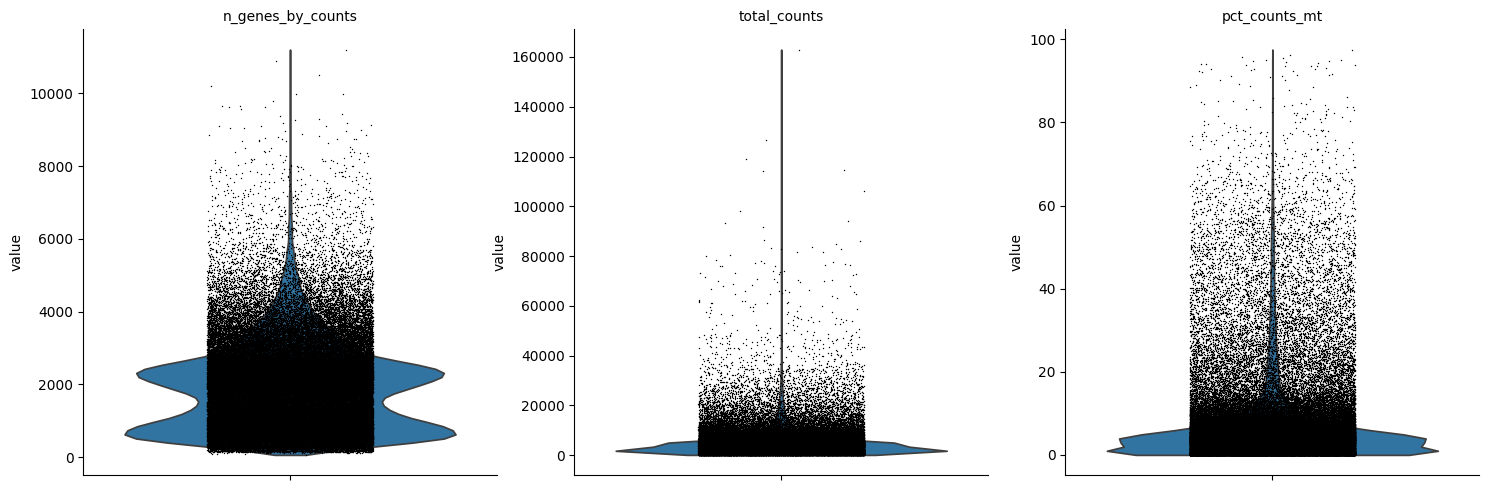

In [10]:
sc.pl.violin(
    adata_all,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.2,
    multi_panel=True,
)

In [11]:
#sc.pl.scatter(adata_all, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [12]:
adata_all

AnnData object with n_obs × n_vars = 108925 × 33696
    obs: 'sample', 'Diet', 'Duration', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [13]:
# Filter cells and genes based on the plot above
sc.pp.filter_cells(adata_all, min_genes=200)
sc.pp.filter_genes(adata_all, min_cells=3)
adata = adata_all[adata_all.obs.pct_counts_mt < 20]

In [14]:
# doublet detection
sc.pp.scrublet(adata, batch_key="sample")

In [15]:
# save the count data
adata.layers["counts"] = adata.X.copy()

In [16]:
# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)

In [18]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")
sc.pl.highly_variable_genes(adata)

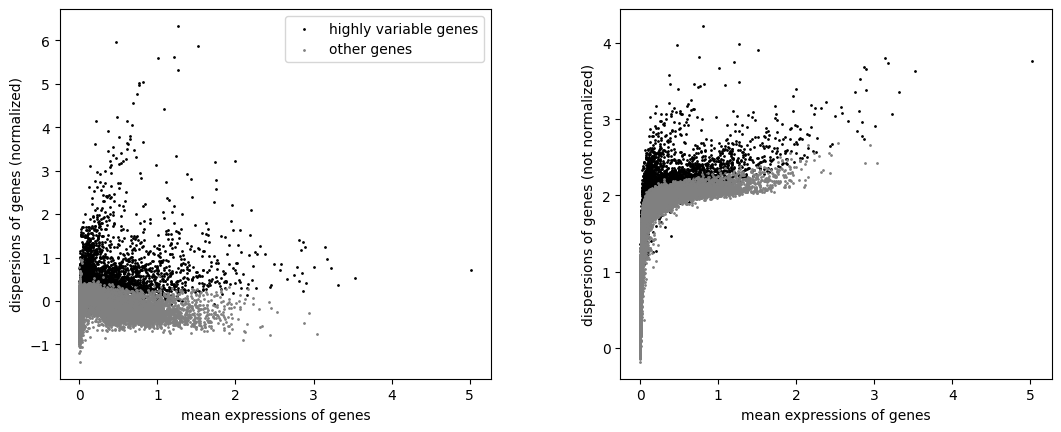

In [ ]:
# Filter the AnnData to only HVGs
# adata = adata[:, adata.var["highly_variable"]]

In [17]:
# this below step is not necessary as sc.tl.pca does the zero-centering on its own
# Scale the data (zero-mean, unit variance)
# sc.pp.scale(adata, max_value=10)

In [ ]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1.0)

In [24]:
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

In [25]:
adata = adata[adata.obs['predicted_doublet'] == False]

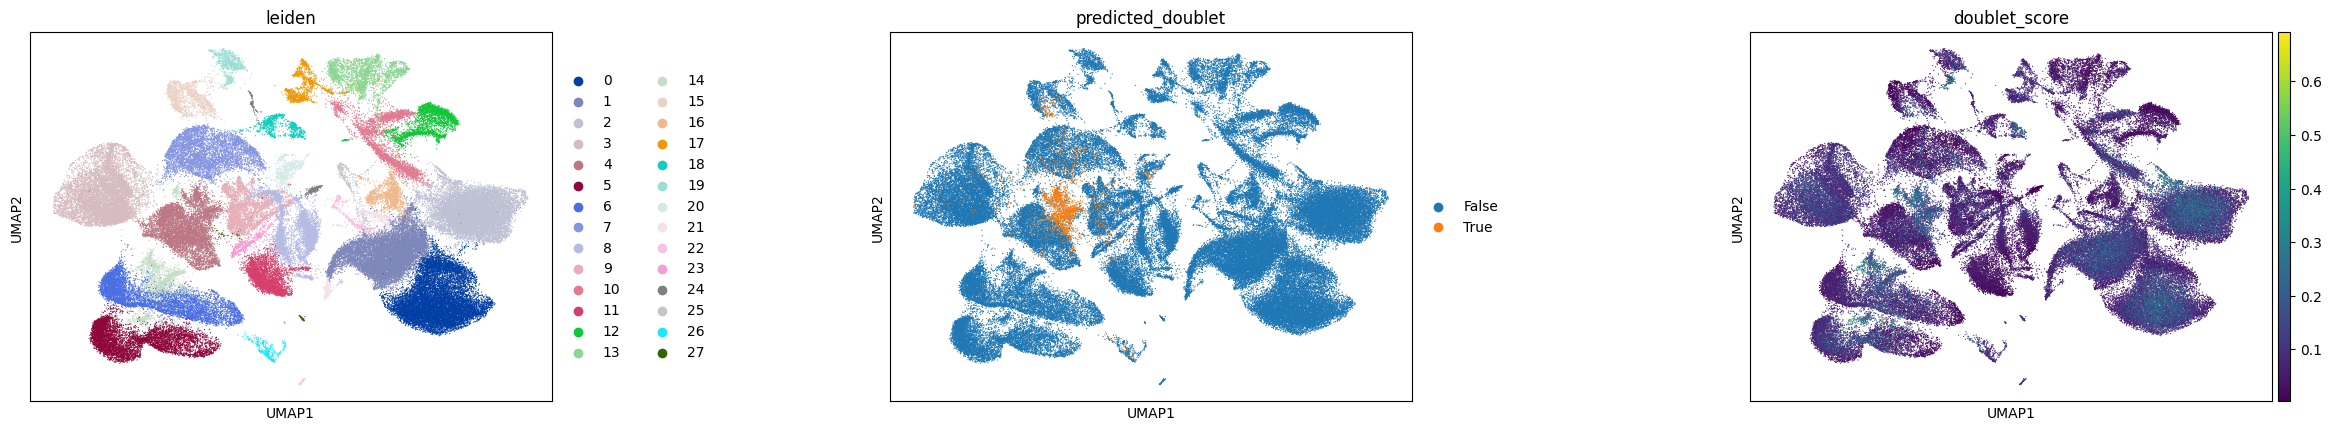

In [26]:
# Visualize the expression of Ptprc in the UMAP plot
sc.pl.umap(adata, color='Ptprc')

In [27]:
# Filter cells with Ptprc expression above 2
adata = adata[adata[:, 'Ptprc'].X < 1]

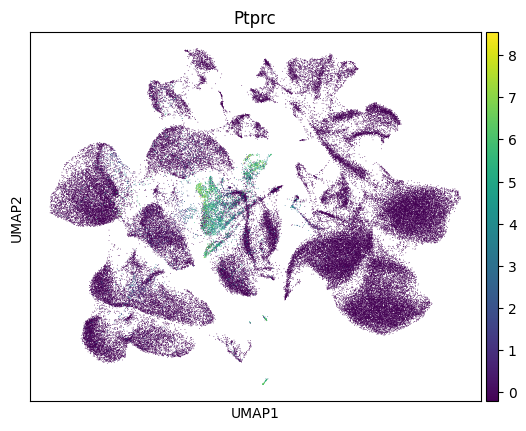

In [28]:
# Save the UMAP plot as a PDF
sc.pl.umap(adata, color=["Diet", "Duration", "sample"], wspace=0.4, save="umap_plot.pdf")

## 2. Batch Correction using BBKNN

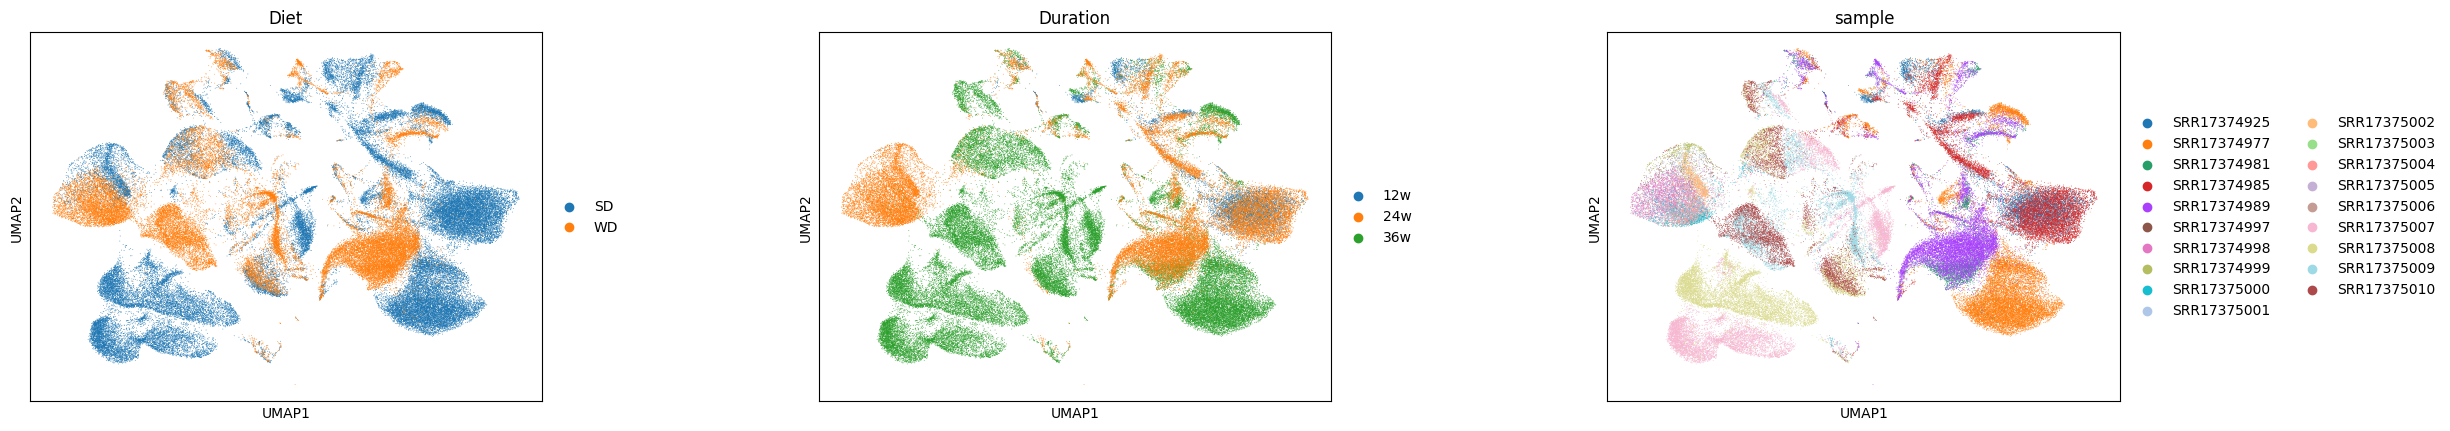

In [30]:
sc.external.pp.bbknn(adata, batch_key="sample")

In [27]:
# Save the combined AnnData object
adata.write("data/mouse_combined_scRNA.h5ad")

In [31]:
sc.tl.umap(adata)

In [32]:
sc.pl.umap(adata, color=["Diet", "Duration", "sample"], wspace=0.4, save="umap_plot_batch_corrected.pdf")

In [33]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', key_added = "wilcoxon")
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

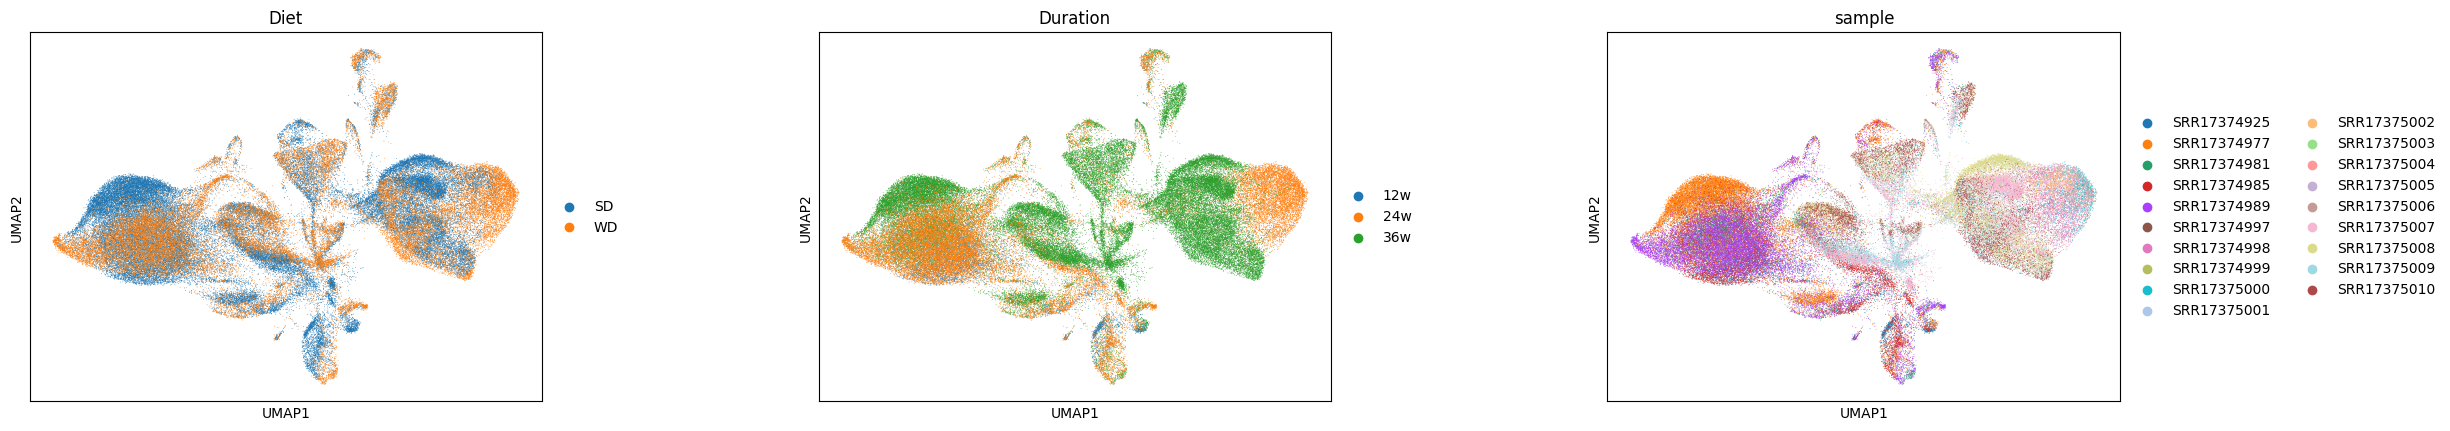

In [34]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, key="wilcoxon", groupby="leiden", show_gene_labels=True)

## 3. DEG analysis of different diet groups

In [ ]:
# Perform DEG analysis between SD and WD diet
sc.tl.rank_genes_groups(adata, groupby = "Diet", method = "wilcoxon")

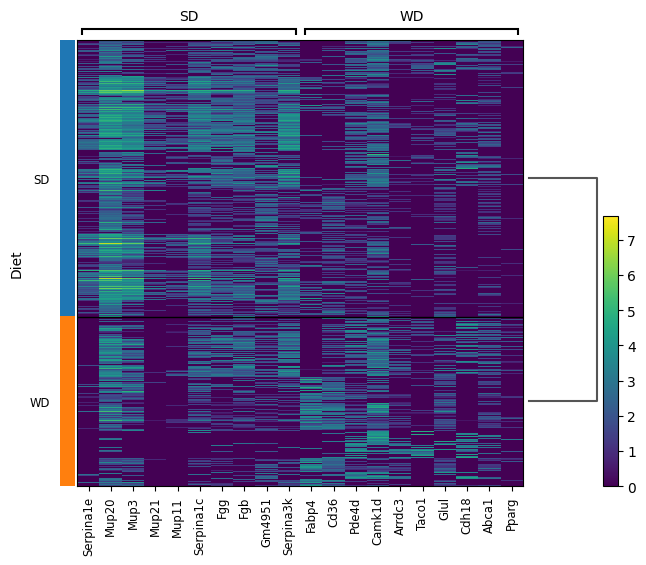

In [ ]:
# Plot heatmap for top differentially expressed genes between SD and WD diet
sc.pl.rank_genes_groups_heatmap(adata, groupby='Diet', n_genes=10, show_gene_labels=True, save="_Diet_DEG.pdf")

/scratch/ipykernel_2786416/1247605138.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_degs['-log10pvals_adj'] = filtered_degs['pvals_adj'].apply(


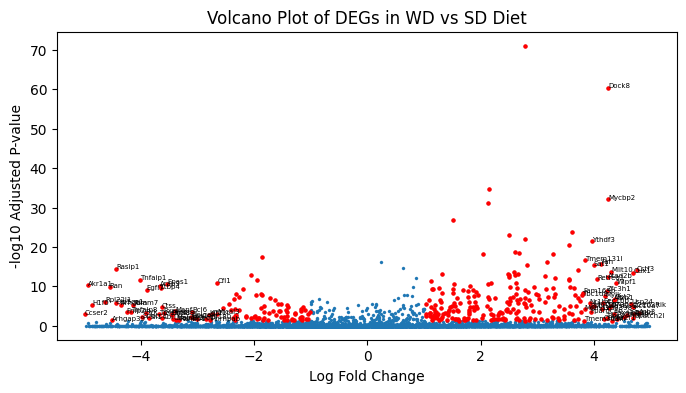

<Figure size 640x480 with 0 Axes>

In [42]:
# Extract the results
degs = sc.get.rank_genes_groups_df(adata, group='WD')

# Filter out genes with p-value >= 0.1
filtered_degs = degs[(degs['logfoldchanges'] <= 5) & (degs['logfoldchanges'] >= -5)]

# Add a new column for -log10 adjusted p-values
filtered_degs['-log10pvals_adj'] = filtered_degs['pvals_adj'].apply(
    lambda x: -np.log10(x) if x > 0 else 0
)

# Create a volcano plot
plt.figure(figsize=(8, 4))
sns.scatterplot(data=filtered_degs, x='logfoldchanges', y='-log10pvals_adj', edgecolor=None, s=5)

# Add labels and title
plt.xlabel('Log Fold Change')
plt.ylabel('-log10 Adjusted P-value')
plt.title('Volcano Plot of DEGs in WD vs SD Diet')

# Highlight significant genes
significant_genes = filtered_degs[(filtered_degs['pvals_adj'] < 0.05) & (abs(filtered_degs['logfoldchanges']) > 1)]
plt.scatter(significant_genes['logfoldchanges'], significant_genes['-log10pvals_adj'], color='red', s=5)

# Annotate the top 5 highest and lowest log fold change genes
top_genes_high = significant_genes[significant_genes['pvals_adj'] < 0.05].nlargest(40, 'logfoldchanges')
top_genes_low = significant_genes[significant_genes['pvals_adj'] < 0.05].nsmallest(40, 'logfoldchanges')
top_genes = pd.concat([top_genes_high, top_genes_low])

for i in range(top_genes.shape[0]):
    plt.text(
        x=top_genes['logfoldchanges'].iloc[i],
        y=top_genes['-log10pvals_adj'].iloc[i],
        s=top_genes['names'].iloc[i],
        fontsize=5
    )

# Save the plot as a PDF
plt.savefig('Western_diet_volcano_plot_batch_corrected.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Save the plot as a PDF
plt.savefig('Western_diet_volcano_plot_batch_corrected.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [35]:
# Extract the DEGs from the Wilcoxon test results for the 'Diet' group
# Extract DEG results from adata.uns['rank_genes_groups']
deg_results = adata.uns['rank_genes_groups']

# Convert to a pandas DataFrame for easier export
groups = deg_results['names'].dtype.names  # Group names (e.g., SD, WD)
filtered_deg_data = []

# Iterate over each group and extract relevant DEG information
for group in groups:
    # Create a DataFrame for the current group
    group_df = pd.DataFrame({
        'Gene': deg_results['names'][group],
        'Score': deg_results['scores'][group],
        'Logfoldchange': deg_results['logfoldchanges'][group],
        'Pval': deg_results['pvals'][group],
        'Adj_pval': deg_results['pvals_adj'][group]
    })
    group_df['Group'] = group  # Add group name

    # Filter genes: Logfoldchange > 1 and Adjusted p-value < 0.05
    filtered_group_df = group_df[
        (group_df['Logfoldchange'] > 1) & (group_df['Adj_pval'] < 0.05)
    ]

    # Add the filtered results to the list
    filtered_deg_data.append(filtered_group_df)

# Combine filtered results for all groups into a single DataFrame
filtered_deg_results_df = pd.concat(filtered_deg_data, ignore_index=True)

# Save to a CSV file
filtered_deg_results_df.to_csv("data/Diet_DEG_batch_corrected.csv", index=False)

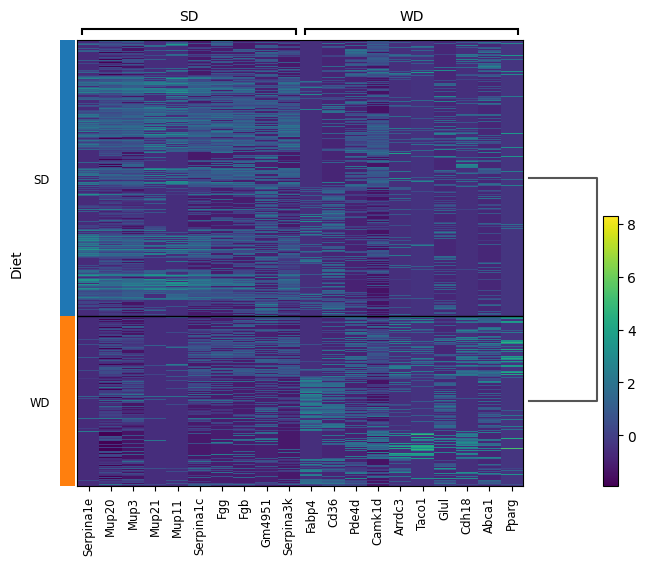

In [36]:
# Save the combined AnnData object
adata.write("data/mouse_combined_scRNA.h5ad")

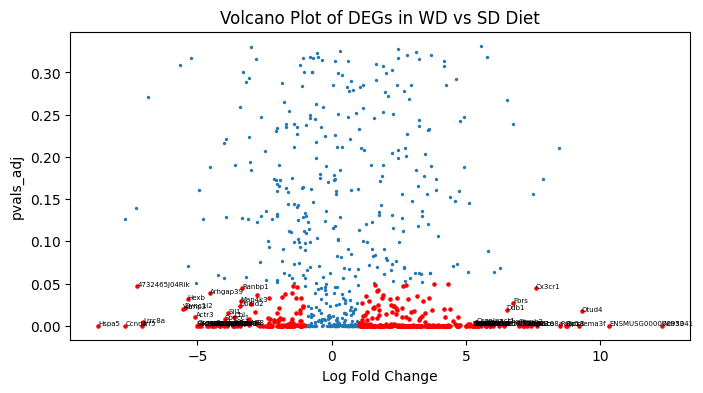

In [ ]:
from gprofiler import GProfiler
# Initialize the GProfiler object
gp = GProfiler(return_dataframe=True)

In [40]:
# Perform GO analysis using g:Profiler
gp_sd = gp.profile(organism='mmusculus', query=sd_genes, sources=['GO:BP', 'GO:MF', 'GO:CC'])
gp_wd = gp.profile(organism='mmusculus', query=wd_genes, sources=['GO:BP', 'GO:MF', 'GO:CC'])

# Convert the results to DataFrames for easier handling
gp_sd_df = gp_sd
gp_wd_df = gp_wd

In [36]:
# Subset rows with Group = WD
wd_deg_results_df = filtered_deg_results_df[filtered_deg_results_df['Group'] == 'WD']

In [ ]:
import biomart

# Initialize the BioMart server
server = biomart.BiomartServer("http://www.ensembl.org/biomart")

# Select the Ensembl Genes dataset for mouse
mart = server.datasets['mmusculus_gene_ensembl']


In [40]:
# Function to query biotype from BioMart
def query_biotype(gene):
    response = mart.search({
        'filters': {
            'external_gene_name': gene
        },
        'attributes': [
            'external_gene_name', 'gene_biotype'
        ]
    })
    results = response.text.strip().split("\n")
    if len(results) > 1:
        return results[1].split("\t")[1]
    else:
        return 'unknown'

# Apply the query_biotype function to the "Gene" column and create a new "biotype" column
wd_deg_results_df['biotype'] = wd_deg_results_df['Gene'].apply(query_biotype)

print(wd_deg_results_df.head())

## 4. 

## 5. GO Pathway Analysis

In [ ]:
# Save the results to CSV files
gp_sd_df.to_csv("data/GO_analysis_SD.csv", index=False)
gp_wd_df.to_csv("data/GO_analysis_WD.csv", index=False)

In [ ]:

# Extract DEG results from adata.uns['rank_genes_groups']
deg_results = adata.uns['rank_genes_groups']

# Convert to a pandas DataFrame for easier export
groups = deg_results['names'].dtype.names  # Group names (e.g., SD, WD)
filtered_deg_data = []

# Iterate over each group and extract relevant DEG information
for group in groups:
    # Create a DataFrame for the current group
    group_df = pd.DataFrame({
        'Gene': deg_results['names'][group],
        'Score': deg_results['scores'][group],
        'Logfoldchange': deg_results['logfoldchanges'][group],
        'Pval': deg_results['pvals'][group],
        'Adj_pval': deg_results['pvals_adj'][group]
    })
    group_df['Group'] = group  # Add group name

    # Filter genes: Logfoldchange > 1 and Adjusted p-value < 0.05
    filtered_group_df = group_df[
        (group_df['Logfoldchange'] > 1) & (group_df['Adj_pval'] < 0.05)
    ]
    # Add the filtered results to the list
    filtered_deg_data.append(filtered_group_df)

# Combine filtered results for all groups into a single DataFrame
filtered_deg_results_df = pd.concat(filtered_deg_data, ignore_index=True)

# Save to a CSV file
filtered_deg_results_df.to_csv("data/Duration_DEG.csv", index=False)

In [37]:
from gprofiler import GProfiler
# Initialize the GProfiler object
gp = GProfiler(return_dataframe=True)